http://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html  
https://discourse.pymc.io/t/dynamical-model-in-pymc3/1012

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as st
import matplotlib.pylab as plt

import theano

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
theano.config.test_values = 'raise'

alpha = tt.dscalar("alpha")
beta = tt.dscalar("beta")
gamma = tt.dscalar("gamma")
delta = tt.dscalar("delta")
Z0 = tt.vector("Z0")
dt = tt.dscalar("dt")
steps = tt.iscalar("steps")


def rhs_ode(y, a, b, c, d, dt):
    yprime = tt.zeros_like(y)
    yprime = tt.set_subtensor(
        yprime[0], y[0] + dt * (a * y[0] - b * y[0] * y[1]))
    yprime = tt.set_subtensor(
        yprime[1], y[1] + dt * (-c * y[1] + d * y[0] * y[1]))
    return yprime


# Symbolic loop through Euler updates
xout, updates = theano.scan(fn=rhs_ode,
                            outputs_info=Z0,
                            non_sequences=[alpha, beta, gamma, delta, dt],
                            n_steps=steps)

simulation = theano.function(inputs=[Z0, alpha, beta, gamma, delta, dt, steps],
                             outputs=xout,
                             updates=updates,
                             allow_input_downcast=True)

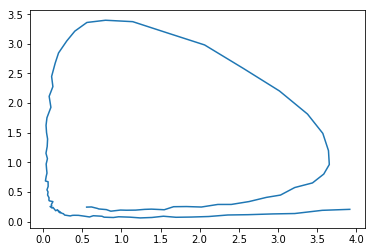

In [44]:
nstep = 100
a, b, c, d, dt = 2.5, 2.5, 1.75, 1.75, .05
data = simulation(np.asarray([.5, 0.25]), a, b, c, d, dt, nstep)+np.random.randn(nstep, 2)*.015
plt.plot(data[:, 0], data[:, 1]);

In [32]:
with pm.Model() as LV_Model:
    # priors
    # test inference using real parameters
    alpha = pm.Normal('alpha', mu=a, sd=1.)
    gamma = pm.Normal('gamma', mu=b, sd=1.)
    beta = pm.Normal('beta', mu=c, sd=1.)
    delta = pm.Normal('delta', mu=d, sd=1.)
    
    sigma = pm.HalfNormal('sigma', sd=.05, shape=2)

    # Initial Conditions
    Z0 = pm.Normal('Z0', mu=0, sd=1, shape=2)

    # Symbolic loop through Euler updates
    xout, updates = theano.scan(fn=rhs_ode,
                                outputs_info=Z0,
                                non_sequences=[alpha, beta, gamma, delta, dt],
                                n_steps=nstep)

    Y_obs = pm.Normal('Y_obs', mu=xout, sd=sigma, observed=data)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Z0, sigma_log__, delta, beta, gamma, alpha]
 10%|█         | 104/1000 [07:21<3:11:46, 12.84s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Only one chain was sampled, this makes it impossible to run some convergence checks
